## EM for a mixture of multivariate student's t

Suppose that independently for $1 \le n \le N$, we have 
\begin{align*}
    z_n &\sim \bm{\pi}, \\
    \tau_n\mid z_n &\sim \mathrm{Ga}\left(\nu_{z_n}/2,\nu_{z_n}/2 \right), \\
    \bm{x}_n \mid \tau_n,z_n &\sim \mathcal{N}\left(\bm{\mu}_{z_n}, \tau_n^{-1}\bm{\Sigma}_{z_n}\right), 
\end{align*}
where only $\bm{x}_n$ are observed. We will use EM to find the mle of the parameters
$$\bm{\theta} = \left(\bm{\pi}, \left(\nu_k, \bm{\mu}_k, \bm{\Sigma}_k\right)_{k=1}^K \right). $$

First we will simulate some data.

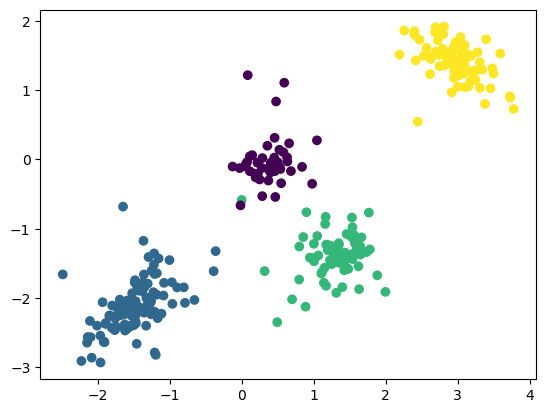

In [313]:
import torch
import matplotlib.pyplot as plt
from pyro.distributions import MultivariateStudentT as MST

torch.manual_seed(2023)

K = 4 # mixture components
D = 2 # data dimension
N = 305 # number of samples

pi_true = torch.distributions.Dirichlet(5*torch.ones(K)).sample()
mus_true = torch.distributions.MultivariateNormal(torch.zeros(D), 2*torch.eye(D)).sample((K,))
Ls_true = torch.distributions.LKJCholesky(D).sample((K,))/4
Sigmas_true = Ls_true @ Ls_true.swapaxes(1,2)
nus_true = torch.distributions.Poisson(3).sample((K,)) + 1

Z_true = torch.distributions.Categorical(pi_true).sample((N,))
X = MST(nus_true[Z_true], mus_true[Z_true], Ls_true[Z_true]).sample()
plt.scatter(X[:,0], X[:,1], c = Z_true)

Now we will implement the E-step. In this step we calculate:
\begin{align*}
    \omega_{nk} &= \frac{\mathrm{St}(\bm{x}_n ; \nu_k,\bm{\mu}_k, \bm{\Sigma}_k)\pi_k}{\sum_{j=1}^K \mathrm{St}(\bm{x}_n ; \nu_j,\bm{\mu}_j, \bm{\Sigma}_j)\pi_j},\\
    \alpha_{nk} &= \frac{\nu_k+D}{2},\\
    \beta_{nk} &= \frac{1}{2}\left(\nu_k + (\bm{x}_n-\bm{\mu}_k)^\top\bm{\Sigma}_k^{-1}(\bm{x}_n - \bm{\mu}_k)\right).
\end{align*}
These paramters give the conditional distribution of the latent variables $\{z_n,\tau_n\}_{n=1}^N$. Specifically, for all $n$ and $k$,
$$p(z_n = k,\tau_n\mid \bm{x}_n;\bm{\theta}) = \omega_{nk}\mathrm{Ga}(\tau_n; \alpha_{nk},\beta_{nk}).$$

In [314]:
A = torch.ones((K,D,D))
b = torch.ones((N,D))
c = torch.ones((K,D))
d = b.unsqueeze(1) - c.unsqueeze(0)

prod = d.unsqueeze(2) * A.unsqueeze(0) * d.unsqueeze(3)
prod.sum(dim = (2,3)).shape

torch.Size([305, 4])

In [315]:
def Estep_Z(X, nus, mus, Sigmas, pi):
    """
    Calculate the conditional distribution of Z given X 
        and the current paramters

    Inputs:
        X - data shape (N,D)
        nus - df parameters shape (K,)
        mus - mean parameters shape (K,D)
        Sigmas - covariance parameters shape (K,D,D)
        log_pi - log mixture proportions shape (K,)

    Output:
        omega - conditional distirbution of Z shape (N,K)
    """

    Ls = torch.linalg.cholesky(Sigmas)
    student = MST(nus, mus, Ls)
    log_omega = torch.log(pi).unsqueeze(0) + student.log_prob(X.unsqueeze(1))
    omega = torch.softmax(log_omega, dim = 1)
    return(omega)
    
def Estep_taus(X, nus, mus, Sigmas):
    """
    Calculate the conditional distribution of Tau given X 
        and the current paramters

    Inputs:
        X - data shape (N,D)
        nus - df parameters shape (K,)
        mus - mean parameters shape (K,D)
        Sigmas - covariance parameters shape (K,D,D)

    Output:
        Paramters for conditional Gamma distribution
        alphas - shape (1,K)
        betas - shape (N,K)
    """
    _, D = X.shape
    alphas = (nus.unsqueeze(0) + D)/2


    diff = X.unsqueeze(1) - mus.unsqueeze(0)
    Sigmas_inv = torch.linalg.inv(Sigmas).unsqueeze(0)
    betas = (diff.unsqueeze(2) * Sigmas_inv * diff.unsqueeze(3)).sum(dim = (2,3))
    betas = (betas + nus.unsqueeze(0))/2
    return(alphas,betas)



Now we will write code for the M-step. The M-step for $\bm{\mu}_k$ and $\bm{\Sigma}_k$ are,
\begin{align*}
    \bm{\mu}^\star &= \sum_{n=1}^N \gamma_{nk} \bm{x}_n,\\
    \bm{\Sigma}_k^\star &= \frac{1}{\sum_{n=1}^N \omega_{nk}^\text{old}} \sum_{n=1}^N \frac{\omega_{nk}^{\mathrm{old}}\alpha_{nk}^{\mathrm{old}}}{\beta_{nk}^{\mathrm{old}}}(\bm{x}_n-\bm{\mu}_k^\star)(\bm{x}_n - \bm{\mu}_k^\star)^\top,
\end{align*}
where $\gamma_{nk} \propto \frac{\omega_{nk}\alpha_{nk}}{\beta_{nk}}$ and $\sum_{n=1}^N \gamma_{nk}=1$ for every $k$.

In [316]:
def Mstep_mu(X, omega, alpha, beta):
    """
    Compute mu_star in the M_step

    Inputs:
        X - data shape (N,D)
        omega - shape (N,K)
        alphas - shape (1,K)
        betas - shape (N,K)

    Output:
        mu_star - shape (K,D)
    """

    gamma_ = omega * alpha / beta 
    gamma = gamma_ / gamma_.sum(dim = 0)
    mus_star = gamma.T @ X
    return(mus_star)

def Mstep_Sigma(X, omega, alpha, beta, mus_star):
    """
    Compute mu_star in the M_step

    Inputs:
        X - data shape (N,D)
        omega - shape (N,K)
        alphas - shape (1,K)
        betas - shape (N,K)
        mus_star - shape (K,D)

    Output:
        mu_star - shape (K,D,D)
    """
    gamma_ = omega * alpha / beta 
    diff = X.unsqueeze(0) - mus_star.unsqueeze(1)
    Sigmas_= (diff.unsqueeze(2) * diff.unsqueeze(3) * gamma_.T.unsqueeze(2).unsqueeze(3)).sum(1)
    Sigmas_star = Sigmas_ / omega.sum(0).reshape((K,1,1))
    return(Sigmas_star)


Next we will do the M-step for $\bm{\pi}$. The update is
$$\pi_k^\star = \frac{\sum_{n=1}^N \omega_{nk}}{\sum_{j=1}^K\sum_{n=1}^N \omega_{nj}} $$

In [317]:
def Mstep_pi(omegas):
    pi_star_ = omegas.sum(0)
    pi_star = pi_star_/pi_star_.sum()
    return(pi_star)

The M-step for $\nu_k$ is more involved. Specifically,
$$\log(v_k^\star) - \psi(v_k^\star) = \frac{B_k+A_k}{A_k} \text{ and } \nu_k^* = 2v_k,$$
where $\psi$ is the digamma function and 
\begin{align*}
    A_k &= \sum_{n=1}^N\omega_{nk},\\
    B_k &= \sum_{n=1}^N \omega_{nk}^{\text{old}}\left(\psi\left(\alpha_{nk}^{\text{old}}\right) - \log\left(\beta_{nk}^{\text{old}}\right)-\alpha_{nk}^{\text{old}}/\beta_{nk}^{\text{old}}\right)
\end{align*}
We will thus do the M-step for $\nu_k$ with a bisection search to find $v_k^*$.

In [318]:
from torch.special import digamma 

def bisection_search(a,b, tol = 1e-6):
    """ 
    Finds v that solves log(v) - psi(v) = (a+b)/2
    """
    target = -(a+b)/a
    assert target > 0, "Target negative" 
    v_upper = torch.exp(target) 
    v_lower = torch.tensor([1])
    while (v_lower.log() - digamma(v_lower) < target):
        v_lower = v_lower/2
    
    while ((v_upper - v_lower).abs() > tol):
        v_new = (v_upper + v_lower)/2
        if (v_new.log() - digamma(v_new) < target):
            v_upper = v_new
        else:
            v_lower = v_new
    return(v_upper)

def Mstep_nu(omegas, alphas, betas):
    """
    Compute nu_star in the M_step

    Inputs:
        omega - shape (N,K)
        alphas - shape (1,K)
        betas - shape (N,K)

    Output:
        nu_star - shape (K,)
    """

    A = omegas.sum(0)
    B_ = omegas * (digamma(alphas) - betas.log() - alphas/betas)
    B = B_.sum(0)
    K = A.shape[0]
    nus_star = torch.zeros(K)
    for k in range(K):
        v = bisection_search(A[k],B[k])
        nus_star[k] = 2*v
    
    return(nus_star)
    


    


In [319]:
bisection_search(torch.tensor([0.1]),torch.tensor([-0.5]))



tensor([0.1861])

In [320]:
def log_likelihood(X, mus, Sigmas, nus, pi):
    Ls = torch.linalg.cholesky(Sigmas)
    StudentT = MST(nus, mus, Ls)
    log_mix = StudentT.log_prob(X.unsqueeze(1)) + pi.log().unsqueeze(0)
    log_probs_ = torch.logsumexp(log_mix, dim = 1)
    return(log_probs_.sum())

In [321]:
log_likelihood(X, mus_true, Sigmas_true, nus_true, pi_true)

tensor(-534.7727)

In [322]:
def EM_student_T(X, mu_0, Sigma_0, nu_0, pi_0, max_iter = 1000, tol = 1e-6):
    log_liks = [] 
    mus = mu_0
    Sigmas = Sigma_0
    nus = nu_0
    pi = pi_0
    log_liks.append(log_likelihood(X, mus, Sigmas, nus, pi))

    for i in range(max_iter - 1):
        omega = Estep_Z(X, nus, mus, Sigmas, pi)
        alpha, beta = Estep_taus(X, nus, mus, Sigmas)


        mus = Mstep_mu(X, omega, alpha, beta)
        Sigmas = Mstep_Sigma(X, omega, alpha, beta, mus)
        pi = Mstep_pi(omega)
        nus = Mstep_nu(omega, alpha, beta)
        log_liks.append(log_likelihood(X, mus, Sigmas, nus, pi))
        if log_liks[i+1] -  log_liks[i] < -tol:
            assert "log likelihood decreased!"
        if log_liks[i+1] -  log_liks[i] < tol:
            break

    return(log_liks, mus, Sigmas, pi, nus)

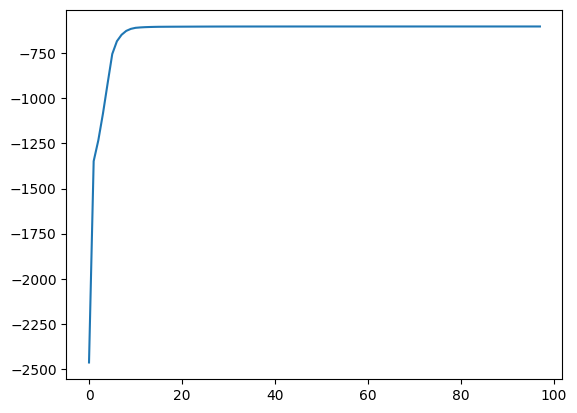

In [323]:
pi_0 = torch.distributions.Dirichlet(5*torch.ones(K)).sample()
mus_0 = torch.distributions.MultivariateNormal(torch.zeros(D), 3*torch.eye(D)).sample((K,))
Ls_0 = torch.distributions.LKJCholesky(D).sample((K,))/4
Sigmas_0 = Ls_true @ Ls_true.swapaxes(1,2)
nus_0 = torch.distributions.Poisson(4).sample((K,)) + 1

l, mus, Sigmas, pi, nus = EM_student_T(X, mus_0, Sigmas_0, nus_0, pi_0)
plt.plot(l)

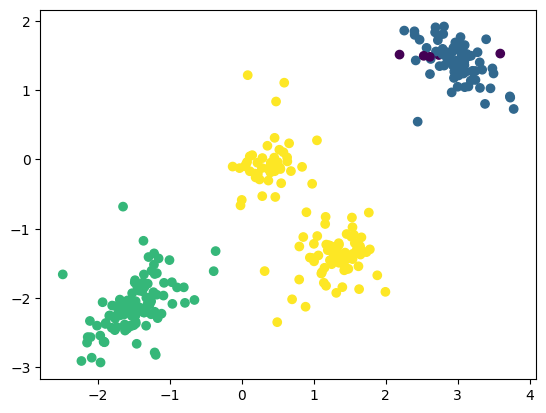

In [324]:
omega = Estep_Z(X, nus, mus, Sigmas, pi)
assignment = omega.argmax(1)
plt.scatter(X[:,0], X[:,1], c = assignment)

We see that the model failed to find all four components and instead got stuck in a local minimum. We can repeat the EM method with a new initial starting point.

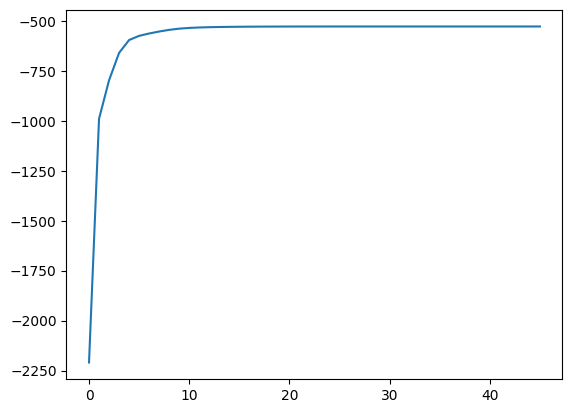

In [325]:
pi_0 = torch.distributions.Dirichlet(5*torch.ones(K)).sample()
mus_0 = torch.distributions.MultivariateNormal(torch.zeros(D), 3*torch.eye(D)).sample((K,))
Ls_0 = torch.distributions.LKJCholesky(D).sample((K,))/4
Sigmas_0 = Ls_true @ Ls_true.swapaxes(1,2)
nus_0 = torch.distributions.Poisson(4).sample((K,)) + 1

l, mus, Sigmas, pi, nus = EM_student_T(X, mus_0, Sigmas_0, nus_0, pi_0)
plt.plot(l)

omega = Estep_Z(X, nus, mus, Sigmas, pi)


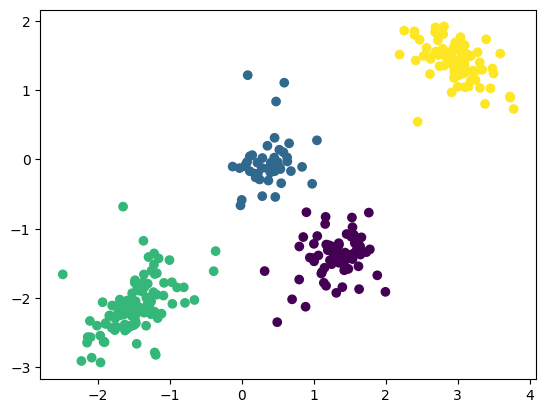

In [326]:
assignment = omega.argmax(1)
plt.scatter(X[:,0], X[:,1], c = assignment)